# SM2 — Summer Thermal Comfort Contest (Sections Ranking + Hypotheses)

This notebook runs a **contest** to identify **the 3 worst** and **the 3 best** SM2 **sections** (sm2_01..sm2_09) in terms of **apartment summer thermal comfort**, using **Atrea** `temp_indoor` as a proxy for indoor apartment temperature.

## Method (overview)
We compute a **composite overheating score** per section for **summers 2024 & 2025** (Europe/Prague):

1. **Days ≥ 27 °C (daily max)** — share of days with `daily_max(temp_indoor) ≥ 27 °C`.
2. **Degree-hours above 26 °C** — sum of `(temp_indoor - 26)+` across observed hours, normalized by observed hours.
3. **Hot nights share** — share of nights where **minimum temp between 22:00–06:00 ≥ 25 °C**.

We normalize these components per year, combine them with weights (0.5, 0.3, 0.2), and rank sections. We also show **per-year podiums** and an **overall podium** (2024+2025 combined).

At the end, we propose **hypotheses** for why certain sections perform worse/better, and list **additional data** that would strengthen or falsify these hypotheses.

**Notes**
- Raw timestamps are UTC; we convert to **Europe/Prague** for daily/night windows.
- Plots use **matplotlib** (one plot per figure; no explicit color styling).
- We report completeness (observed hours/days) so you can judge data coverage.


In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Download & Load (Parquet preferred)

In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Check IDs or internet access.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 111MB/s]


Shape: (651332, 6)


,time,location,source,measurement,data_key,data_value
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4


## Filter to Atrea `temp_indoor` & derive local fields

- We compute metrics for **summers 2024 & 2025**: **June 1 – Aug 31** (Europe/Prague).

In [3]:
atr = df[(df['source']=='Atrea') & (df['data_key']=='temp_indoor')].copy()
atr['local_time'] = atr['time'].dt.tz_convert('Europe/Prague')
atr['local_day'] = atr['local_time'].dt.floor('D')
atr['year'] = atr['local_time'].dt.year

SUMMER_START = {2024: pd.Timestamp('2024-06-01', tz='Europe/Prague'), 2025: pd.Timestamp('2025-06-01', tz='Europe/Prague')}
SUMMER_END   = {2024: pd.Timestamp('2024-08-31', tz='Europe/Prague'), 2025: pd.Timestamp('2025-08-31', tz='Europe/Prague')}

def summer_rows(frame: pd.DataFrame) -> pd.DataFrame:
    return frame[(
        ((frame['year']==2024) & (frame['local_day']>=SUMMER_START[2024]) & (frame['local_day']<=SUMMER_END[2024])) |
        ((frame['year']==2025) & (frame['local_day']>=SUMMER_START[2025]) & (frame['local_day']<=SUMMER_END[2025]))
    )].copy()

atr_summer = summer_rows(atr)
print('Atrea temp_indoor — summer rows:', len(atr_summer))


Atrea temp_indoor — summer rows: 37746


## KPI functions (per section & per year)

We compute three KPIs and then a weighted composite score:
- `over27_rate` — share of summer days with daily max ≥ 27 °C.
- `deg_hours_26` — degree-hours above 26 °C per observed hour (mean excess).
- `hot_nights_rate` — share of nights (22:00–06:00) with min ≥ 25 °C.

Weights: **0.5, 0.3, 0.2** respectively. Each KPI is **min-max normalized per year** prior to weighting.

In [4]:
def kpi_over27_rate(frame: pd.DataFrame) -> pd.DataFrame:
    dmax = (frame.groupby(['location','local_day'])['data_value']
                  .max()
                  .reset_index(name='daily_max'))
    dmax['year'] = dmax['local_day'].dt.year
    out = (dmax.groupby(['location','year'])
                .agg(days_observed=('local_day','nunique'),
                     days_over_27=('daily_max', lambda s: int((s>=27.0).sum())))
                .reset_index())
    out['over27_rate'] = out['days_over_27'] / out['days_observed']
    return out

def kpi_deg_hours(frame: pd.DataFrame) -> pd.DataFrame:
    # degree-hours above 26 per observed hour
    f = frame.copy()
    f['excess'] = (f['data_value'] - 26.0).clip(lower=0)
    out = (f.groupby(['location','year'])
             .agg(hours_present=('local_time', lambda s: s.dt.floor('h').nunique()),
                  deg_hours=('excess','sum'))
             .reset_index())
    out['deg_hours_26'] = out['deg_hours'] / out['hours_present']
    return out

def kpi_hot_nights_rate(frame: pd.DataFrame) -> pd.DataFrame:
    # Define nights: 22:00..06:00 (bridge to next day). We'll anchor by start day at 22:00.
    f = frame.copy()
    f['date'] = f['local_time'].dt.date
    f['hour'] = f['local_time'].dt.hour
    # Night start key: if hour >=22, night belongs to that date; else belongs to previous date
    f['night_start'] = np.where(f['hour']>=22, pd.to_datetime(f['date']), pd.to_datetime(f['date']) - pd.Timedelta(days=1))
    # Keep only hours 22..23 or 0..5
    f_night = f[((f['hour']>=22) | (f['hour']<=5))].copy()
    # Aggregate min temp per night per location
    nmin = (f_night.groupby(['location','night_start','year'])['data_value']
                    .min()
                    .reset_index(name='night_min'))
    out = (nmin.groupby(['location','year'])
                .agg(nights_observed=('night_start','nunique'),
                     nights_hot=('night_min', lambda s: int((s>=25.0).sum())))
                .reset_index())
    out['hot_nights_rate'] = out['nights_hot'] / out['nights_observed']
    return out

k1 = kpi_over27_rate(atr_summer)
k2 = kpi_deg_hours(atr_summer)
k3 = kpi_hot_nights_rate(atr_summer)

metrics = k1.merge(k2, on=['location','year'], how='outer').merge(k3, on=['location','year'], how='outer')
metrics


,location,year,days_observed,days_over_27,over27_rate,hours_present,deg_hours,deg_hours_26,nights_observed,nights_hot,hot_nights_rate
0,sm2_01,2024,92,78,0.847826,2208,5819.20,2.635507,93,93,1.000000
1,sm2_01,2025,83,65,0.783133,1986,2510.50,1.264099,83,83,1.000000
2,sm2_02,2024,92,75,0.815217,2208,4766.30,2.158650,93,93,1.000000
3,sm2_02,2025,83,66,0.795181,1986,2535.25,1.276561,83,83,1.000000
4,sm2_03,2024,92,78,0.847826,2208,5515.10,2.497781,93,93,1.000000
5,sm2_03,2025,83,70,0.843373,1986,2618.25,1.318353,83,83,1.000000
6,sm2_04,2024,92,75,0.815217,2208,5215.60,2.362138,93,93,1.000000
7,sm2_04,2025,83,58,0.698795,1986,1911.40,0.962437,83,80,0.963855
8,sm2_05,2024,92,75,0.815217,2208,4229.90,1.915716,93,93,1.000000
9,sm2_05,2025,83,47,0.566265,1986,1247.00,0.627895,83,79,0.951807


## Composite score & per-year rankings

Min-max normalize KPIs **per year**, then compute:

`score = 0.5 * over27_rate_norm + 0.3 * deg_hours_26_norm + 0.2 * hot_nights_rate_norm`

We output podiums (worst/best 3) for **2024** and **2025**.

In [5]:
def minmax_norm(s: pd.Series) -> pd.Series:
    if s.empty: return s
    mn, mx = s.min(), s.max()
    if pd.isna(mn) or pd.isna(mx) or mx==mn:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - mn) / (mx - mn)

scored = metrics.copy()
scored[['over27_rate_norm','deg_hours_26_norm','hot_nights_rate_norm']] = (
    scored.groupby('year')[['over27_rate','deg_hours_26','hot_nights_rate']]
          .transform(minmax_norm)
)
scored['score'] = 0.5*scored['over27_rate_norm'] + 0.3*scored['deg_hours_26_norm'] + 0.2*scored['hot_nights_rate_norm']
scored = scored.sort_values(['year','score'], ascending=[True, False])
display(scored)
scored.to_csv(OUT_DIR / 'section_scores_per_year.csv', index=False)
print('Saved:', OUT_DIR / 'section_scores_per_year.csv')

def podium(df_year: pd.DataFrame, top_n=3):
    worst = df_year.sort_values('score', ascending=False).head(top_n)
    best  = df_year.sort_values('score', ascending=True).head(top_n)
    return worst, best

for y in [2024, 2025]:
    sub = scored[scored['year']==y]
    if sub.empty:
        print(f'No data for {y}')
        continue
    worst, best = podium(sub, 3)
    print(f"\n=== {y} — Worst 3 ===")
    display(worst[['location','score','over27_rate','deg_hours_26','hot_nights_rate','days_over_27','days_observed','hours_present','nights_hot','nights_observed']])
    worst.to_csv(OUT_DIR / f'podium_worst_{y}.csv', index=False)
    print(f"Saved: {OUT_DIR / f'podium_worst_{y}.csv'}")
    print(f"\n=== {y} — Best 3 ===")
    display(best[['location','score','over27_rate','deg_hours_26','hot_nights_rate','days_over_27','days_observed','hours_present','nights_hot','nights_observed']])
    best.to_csv(OUT_DIR / f'podium_best_{y}.csv', index=False)
    print(f"Saved: {OUT_DIR / f'podium_best_{y}.csv'}")


,location,year,days_observed,days_over_27,over27_rate,hours_present,deg_hours,deg_hours_26,nights_observed,nights_hot,hot_nights_rate,over27_rate_norm,deg_hours_26_norm,hot_nights_rate_norm,score
0,sm2_01,2024,92,78,0.847826,2208,5819.20,2.635507,93,93,1.000000,1.000000,1.000000,1.0000,1.000000
4,sm2_03,2024,92,78,0.847826,2208,5515.10,2.497781,93,93,1.000000,1.000000,0.877626,1.0000,0.963288
6,sm2_04,2024,92,75,0.815217,2208,5215.60,2.362138,93,93,1.000000,0.727273,0.757103,1.0000,0.790767
2,sm2_02,2024,92,75,0.815217,2208,4766.30,2.158650,93,93,1.000000,0.727273,0.576298,1.0000,0.736526
8,sm2_05,2024,92,75,0.815217,2208,4229.90,1.915716,93,93,1.000000,0.727273,0.360443,1.0000,0.671769
10,sm2_06,2024,92,75,0.815217,2208,3831.50,1.735281,93,92,0.989247,0.727273,0.200121,0.9000,0.603673
12,sm2_07,2024,92,73,0.793478,2208,3711.80,1.681069,93,85,0.913978,0.545455,0.151952,0.2000,0.358313
14,sm2_08,2024,92,70,0.760870,2208,4880.40,2.210326,93,83,0.892473,0.272727,0.622213,0.0000,0.323028
16,sm2_09,2024,92,67,0.728261,2208,3334.20,1.510054,93,91,0.978495,0.000000,0.000000,0.8000,0.160000
5,sm2_03,2025,83,70,0.843373,1986,2618.25,1.318353,83,83,1.000000,1.000000,1.000000,1.0000,1.000000


Saved: outputs/section_scores_per_year.csv

=== 2024 — Worst 3 ===


,location,score,over27_rate,deg_hours_26,hot_nights_rate,days_over_27,days_observed,hours_present,nights_hot,nights_observed
0,sm2_01,1.000000,0.847826,2.635507,1.0,78,92,2208,93,93
4,sm2_03,0.963288,0.847826,2.497781,1.0,78,92,2208,93,93
6,sm2_04,0.790767,0.815217,2.362138,1.0,75,92,2208,93,93


Saved: outputs/podium_worst_2024.csv

=== 2024 — Best 3 ===


,location,score,over27_rate,deg_hours_26,hot_nights_rate,days_over_27,days_observed,hours_present,nights_hot,nights_observed
16,sm2_09,0.160000,0.728261,1.510054,0.978495,67,92,2208,91,93
14,sm2_08,0.323028,0.760870,2.210326,0.892473,70,92,2208,83,93
12,sm2_07,0.358313,0.793478,1.681069,0.913978,73,92,2208,85,93


Saved: outputs/podium_best_2024.csv

=== 2025 — Worst 3 ===


,location,score,over27_rate,deg_hours_26,hot_nights_rate,days_over_27,days_observed,hours_present,nights_hot,nights_observed
5,sm2_03,1.000000,0.843373,1.318353,1.0,70,83,1986,83,83
3,sm2_02,0.934166,0.795181,1.276561,1.0,66,83,1986,83,83
1,sm2_01,0.916945,0.783133,1.264099,1.0,65,83,1986,83,83


Saved: outputs/podium_worst_2025.csv

=== 2025 — Best 3 ===


,location,score,over27_rate,deg_hours_26,hot_nights_rate,days_over_27,days_observed,hours_present,nights_hot,nights_observed
15,sm2_08,0.000000,0.361446,0.526511,0.807229,30,83,1986,67,83
17,sm2_09,0.051765,0.409639,0.531168,0.807229,34,83,1986,67,83
13,sm2_07,0.326664,0.542169,0.695871,0.879518,45,83,1986,73,83


Saved: outputs/podium_best_2025.csv


## Overall ranking (2024 + 2025 combined)

We also compute a **combined score** by re-normalizing KPIs on the **union of both summers** and recomputing the composite. This gives an **overall podium**.

,location,score,over27_rate,deg_hours_26,hot_nights_rate
2,sm2_03,0.894235,0.845600,1.908067,1.000000
0,sm2_01,0.869208,0.815479,1.949803,1.000000
1,sm2_02,0.825610,0.805199,1.717606,1.000000
3,sm2_04,0.749449,0.757006,1.662287,0.981928
4,sm2_05,0.619533,0.690741,1.271805,0.975904
5,sm2_06,0.575025,0.702789,1.262555,0.922334
6,sm2_07,0.501995,0.667823,1.188470,0.896748
8,sm2_09,0.372443,0.568950,1.020611,0.892862
7,sm2_08,0.369284,0.561158,1.368418,0.849851


Saved: outputs/overall_section_scores.csv

=== Overall — Worst 3 ===


,location,score,over27_rate,deg_hours_26,hot_nights_rate
2,sm2_03,0.894235,0.845600,1.908067,1.0
0,sm2_01,0.869208,0.815479,1.949803,1.0
1,sm2_02,0.825610,0.805199,1.717606,1.0



=== Overall — Best 3 ===


,location,score,over27_rate,deg_hours_26,hot_nights_rate
7,sm2_08,0.369284,0.561158,1.368418,0.849851
8,sm2_09,0.372443,0.568950,1.020611,0.892862
6,sm2_07,0.501995,0.667823,1.188470,0.896748


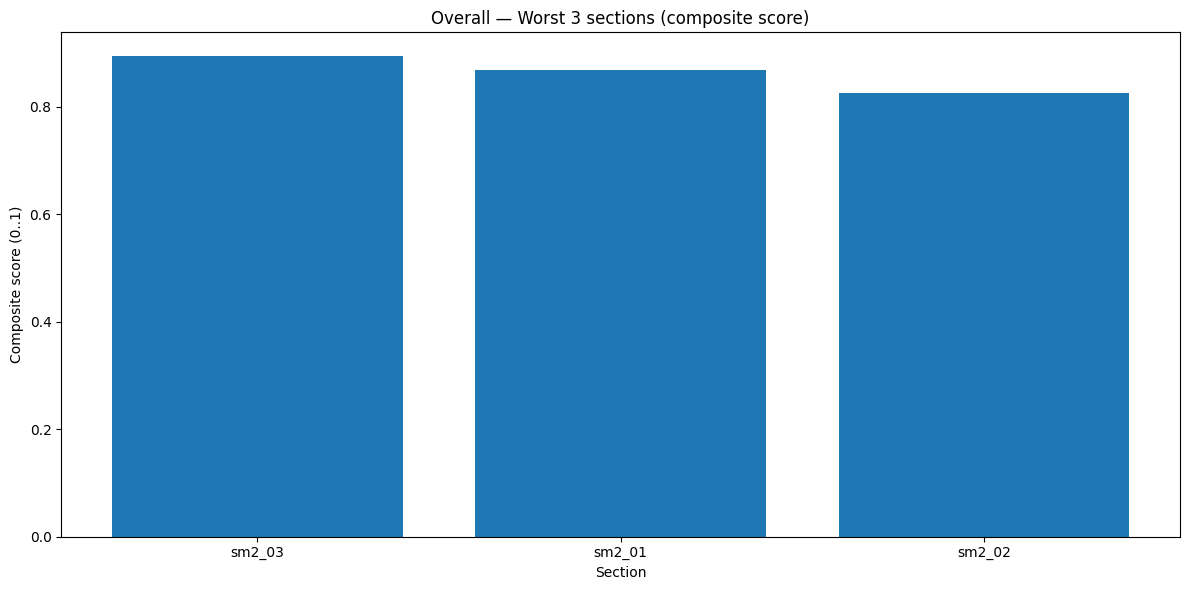

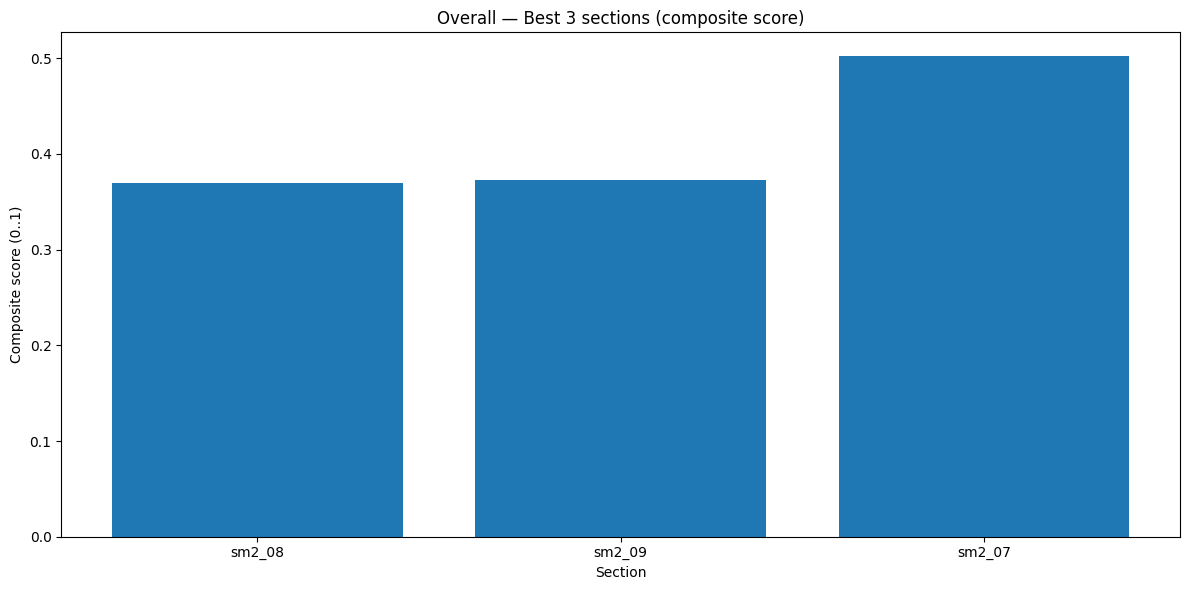

Saved overall podium charts in outputs/


In [6]:
combined = metrics.copy()
for col in ['over27_rate','deg_hours_26','hot_nights_rate']:
    combined[col+'_norm'] = minmax_norm(combined[col])
combined['score'] = 0.5*combined['over27_rate_norm'] + 0.3*combined['deg_hours_26_norm'] + 0.2*combined['hot_nights_rate_norm']
overall = (combined.groupby('location')
                    .agg(score=('score','mean'),
                         over27_rate=('over27_rate','mean'),
                         deg_hours_26=('deg_hours_26','mean'),
                         hot_nights_rate=('hot_nights_rate','mean'))
                    .reset_index()
                    .sort_values('score', ascending=False))

display(overall)
overall.to_csv(OUT_DIR / 'overall_section_scores.csv', index=False)
print('Saved:', OUT_DIR / 'overall_section_scores.csv')

overall_worst = overall.head(3)
overall_best  = overall.tail(3).sort_values('score')
print('\n=== Overall — Worst 3 ===')
display(overall_worst)
print('\n=== Overall — Best 3 ===')
display(overall_best)

# Bar charts for overall podiums
fig = plt.figure(); ax = plt.gca()
ax.bar(overall_worst['location'].astype(str), overall_worst['score'].values)
ax.set_title('Overall — Worst 3 sections (composite score)')
ax.set_xlabel('Section'); ax.set_ylabel('Composite score (0..1)')
plt.tight_layout(); plt.savefig(OUT_DIR / 'overall_worst3_bar.png', dpi=150); plt.show()

fig = plt.figure(); ax = plt.gca()
ax.bar(overall_best['location'].astype(str), overall_best['score'].values)
ax.set_title('Overall — Best 3 sections (composite score)')
ax.set_xlabel('Section'); ax.set_ylabel('Composite score (0..1)')
plt.tight_layout(); plt.savefig(OUT_DIR / 'overall_best3_bar.png', dpi=150); plt.show()
print('Saved overall podium charts in outputs/')


## Drill-down visuals for podiums

For the **overall worst 3** and **best 3**, we show:
- Distribution of **daily maxima** (summer 2024+2025)
- Hour-of-day **mean profiles** (summer 2024+2025)

/tmp/ipython-input-2398467092.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_lists, labels=labels)


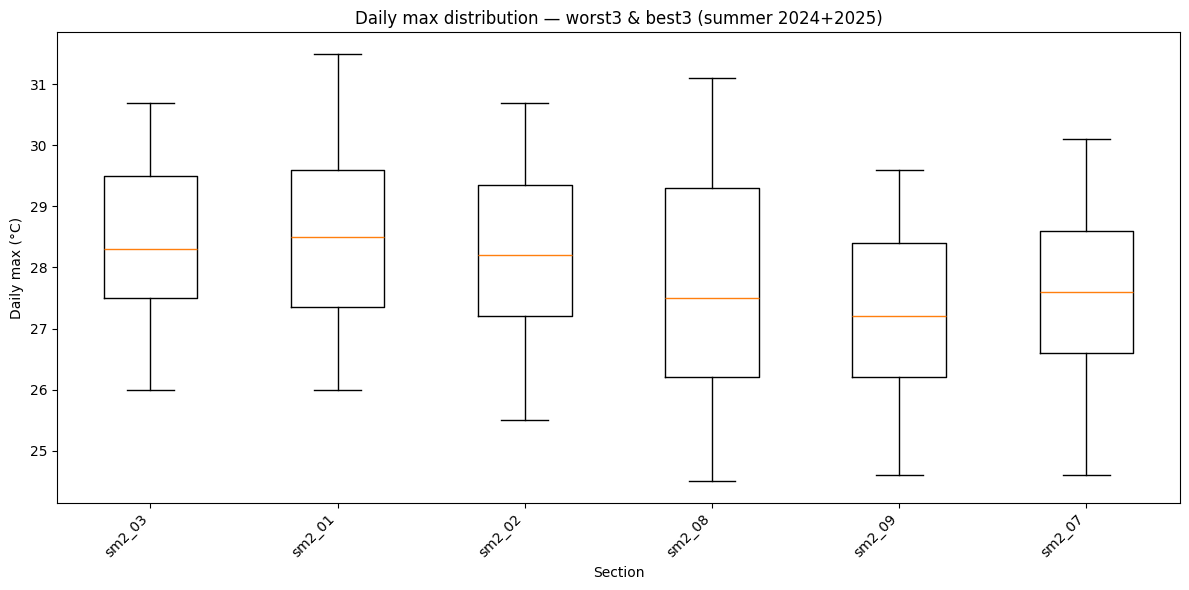

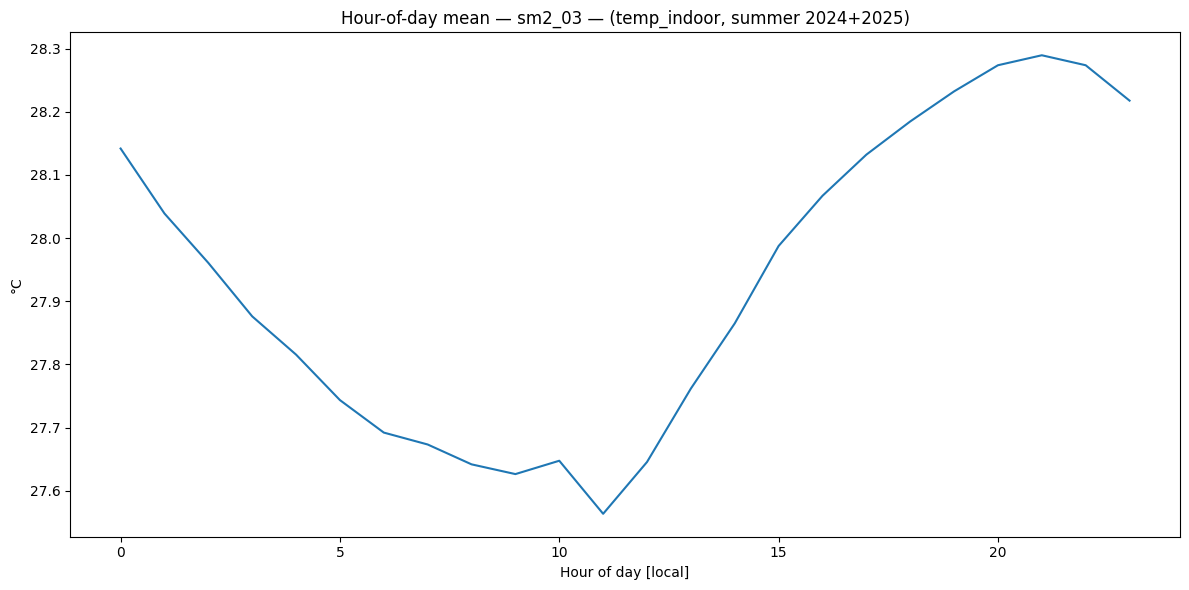

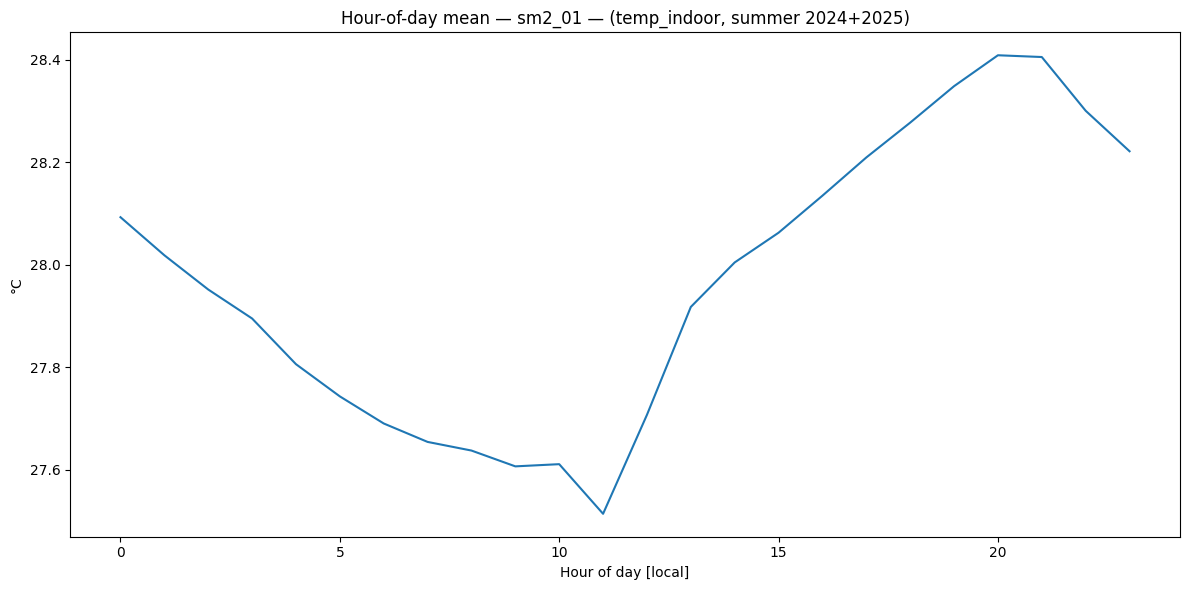

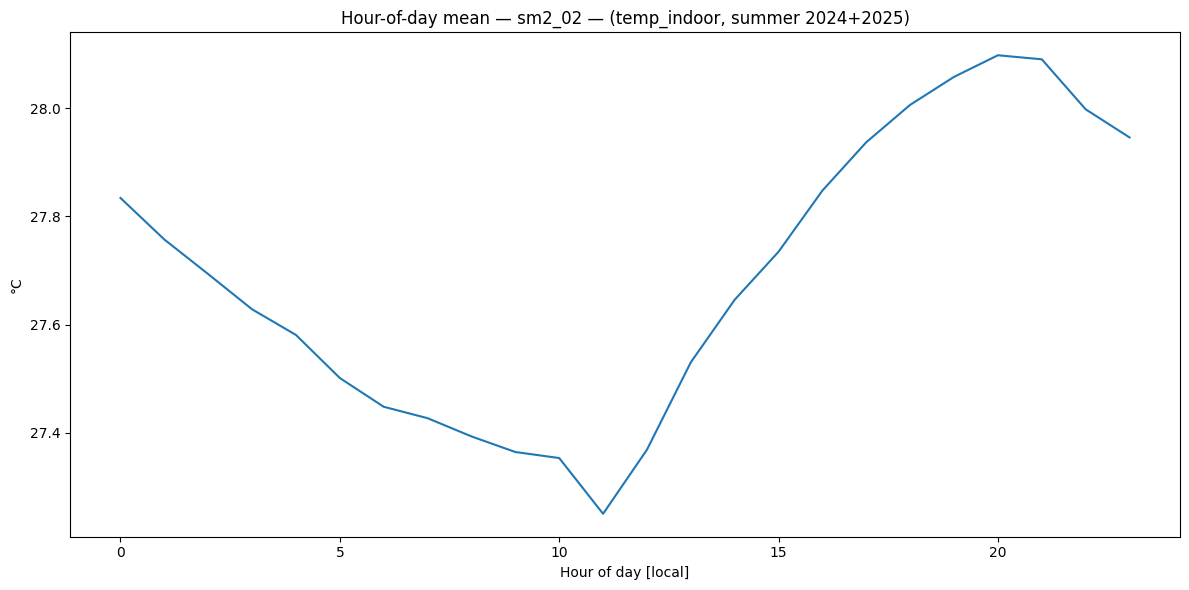

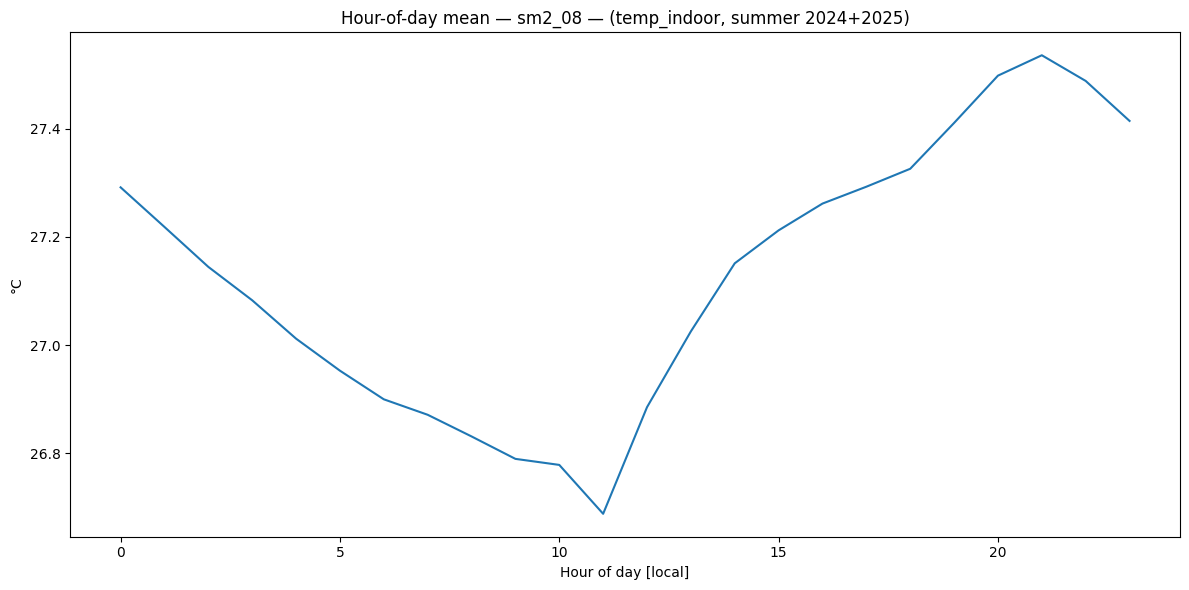

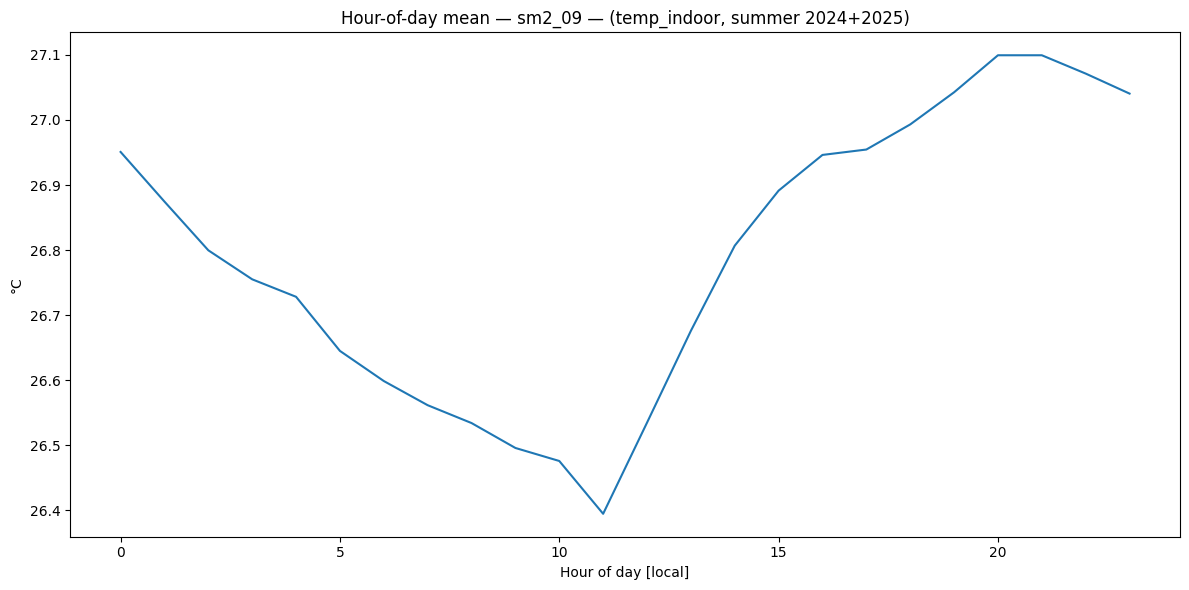

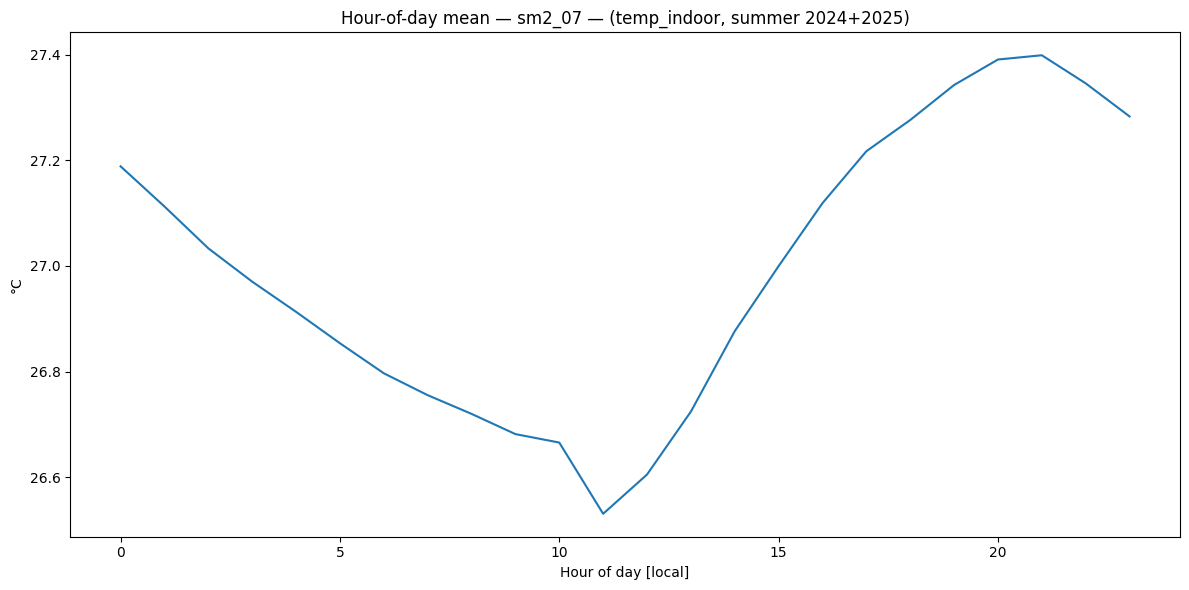

Saved drill-down charts for podium sections in outputs/


In [7]:
# Daily max distribution (boxplots)
dmax_all = (atr_summer.groupby(['location','local_day'])['data_value']
                     .max()
                     .reset_index(name='daily_max'))

targets = list(overall_worst['location'].tolist()) + list(overall_best['location'].tolist())
labels, data_lists = [], []
for loc in targets:
    vals = dmax_all.loc[dmax_all['location']==loc, 'daily_max'].dropna().values
    if len(vals)>=3:
        labels.append(loc)
        data_lists.append(vals)

if data_lists:
    fig = plt.figure(); ax = plt.gca()
    ax.boxplot(data_lists, labels=labels)
    ax.set_title('Daily max distribution — worst3 & best3 (summer 2024+2025)')
    ax.set_xlabel('Section'); ax.set_ylabel('Daily max (°C)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.savefig(OUT_DIR / 'podiums_dailymax_boxplots.png', dpi=150); plt.show()
else:
    print('Not enough data for boxplots.')

# Hour-of-day profiles
atr_summer['hod'] = atr_summer['local_time'].dt.hour
for loc in targets:
    sub = atr_summer[atr_summer['location']==loc]
    if sub.empty: continue
    hod = sub.groupby('hod')['data_value'].mean().reset_index()
    fig = plt.figure(); ax = plt.gca()
    ax.plot(hod['hod'], hod['data_value'])
    ax.set_title(f'Hour-of-day mean — {loc} — (temp_indoor, summer 2024+2025)')
    ax.set_xlabel('Hour of day [local]'); ax.set_ylabel('°C')
    plt.tight_layout(); plt.savefig(OUT_DIR / f'hod_profile_{loc}.png', dpi=150); plt.show()
print('Saved drill-down charts for podium sections in outputs/')


## Hypotheses: why some sections overheat more (and what data to collect)

Below are **testable hypotheses** explaining differences, and the **data** needed to validate them:

1) **Solar gains / orientation**: Sections with larger south/west glazing overheat more.
   - *Data needed*: per-section window orientation & area, glazing SHGC / U-value, shading presence (blinds/awnings), facade albedo.
2) **Shading behavior**: Lack of external shading or low shading usage increases peaks.
   - *Data needed*: per-section shading inventory and usage logs (where available), survey-based shading practices.
3) **Ventilation effectiveness**: HRV/vent flows and corridor ventilation impact night cooling.
   - *Data needed*: per-section HRV supply/exhaust rates, control modes, filters/maintenance logs; corridor window operability; door opening sensor logs.
4) **Internal gains**: Higher occupancy or appliance usage raises base temperature.
   - *Data needed*: occupancy proxies (wifi/client counts, electricity consumption), appliance schedules, server rooms.
5) **Thermal mass coupling**: Stronger coupling to hot garages/corridors elevates apartment temps.
   - *Data needed*: structural adjacency maps, shaft locations, temperature gradients across floors, PP heat source runtime (split AC units).
6) **Microclimate exposure**: Sections with less wind or more reflected sun (courtyards) overheat more.
   - *Data needed*: site wind measurements or modeled wind fields; surrounding surface temps; satellite thermal imagery snapshots during heatwaves.

### How to prove/disprove
- **Regression/feature importance**: build a model of overheating score vs the features above.
- **Intervention tests**: e.g., add shading to a section, increase night ventilation, then re-run metrics.
- **Counterfactual days**: match ambient conditions (Atrea `temp_ambient`) across sections to isolate internal drivers.
